## Feature Selection
##### Loading training data and testing data at first, then split the data objects and target objects.

In [1]:
import pandas as pd
import numpy as np

train_data = pd.read_csv("./SPECTF_train.csv")
y_train = train_data.pop("DIAGNOSIS").values
X_train = train_data.values
train_data.head(5)

,F1R,F1S,F2R,F2S,F3R,F3S,F4R,F4S,F5R,F5S,...,F18R,F18S,F19R,F19S,F20R,F20S,F21R,F21S,F22R,F22S
0,59,52,70,67,73,66,72,61,58,52,...,66,56,62,56,72,62,74,74,64,67
1,72,62,69,67,78,82,74,65,69,63,...,65,71,63,60,69,73,67,71,56,58
2,71,62,70,64,67,64,79,65,70,69,...,73,70,66,65,64,55,61,41,51,46
3,69,71,70,78,61,63,67,65,59,59,...,61,61,66,65,72,73,68,68,59,63
4,70,66,61,66,61,58,69,69,72,68,...,67,69,70,66,70,64,60,55,49,41


In [2]:
test_data = pd.read_csv("./SPECTF_test.csv")
y_test = test_data.pop("DIAGNOSIS").values
X_test = test_data.values
test_data.head(5)

,F1R,F1S,F2R,F2S,F3R,F3S,F4R,F4S,F5R,F5S,...,F18R,F18S,F19R,F19S,F20R,F20S,F21R,F21S,F22R,F22S
0,67,68,73,78,65,63,67,60,63,62,...,61,56,76,75,74,77,76,74,59,68
1,75,74,71,71,62,58,70,64,71,68,...,66,62,68,69,69,66,64,58,57,52
2,83,64,66,67,67,74,74,72,64,68,...,67,64,69,63,68,54,65,64,43,42
3,72,66,65,65,64,61,71,78,73,69,...,69,68,68,63,71,72,65,63,58,60
4,62,60,69,61,63,63,70,68,70,65,...,66,66,58,56,72,73,71,64,49,42


##### Creating a Gradient Boosting Classifier, set `random_state` as 0, which is easier to analyse because we can get unchanging results.
##### Also the `n_estimators`, which means the number of boosting stages to perform, is set as 500, 
##### because Gradient boosting is fairly robust to overfitting and a large number usually results in better performance.

In [3]:
from sklearn import ensemble
gb = ensemble.GradientBoostingClassifier(n_estimators= 500, random_state=0)

## Information Gain filtering.
##### calculating each element's IG score and sort them through a data frame.
##### Every time it will get different IG scores for each variable and different ranks if we do not set a seed value. For easier analytics, we set `random_state` in ` mutual_info_classif` function as 0. Therefore, we can get unchanging IG scores.

In [5]:
from sklearn.feature_selection import mutual_info_classif
i_scores = mutual_info_classif(X_train,y_train, random_state = 0)
# put IG result into a data frame and sort
IG_DF = pd.DataFrame(i_scores,index = train_data.columns, columns =['I-Gain'])
IG_DF.sort_values(by=['I-Gain'],ascending=False,inplace= True)
IG_DF

,I-Gain
F21R,0.187115
F15S,0.177120
F11S,0.172292
F20S,0.172210
F13R,0.158611
F6S,0.117486
F21S,0.115408
F5R,0.102680
F13S,0.102203
F5S,0.099816


### select the best K features based on IG scores and cross validation
##### 1. Start with the feature with the highest IG score.
##### 2. Mesure the accuracy for the data subset based on cross validation.
##### 3. Add the next feature with the highest IG score in the left dataset to this subset.
##### 4. Repeat the step 2 and step 3 until there is no variable left.
##### The process shown above is similar to the `SelectKBest`. But in `SelectKBest` function, we cannot set a random seed for IG score calculation. It could lead to the different accuracy ranks, and different results of selected features. For convenience, using the method shown above and the unchanging IG scores is easier for analytics.

In [6]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

n = len(train_data.columns)
test_score = []
for i in range(n):
    X_train_new = train_data[IG_DF.index[:i+1]].values
    temp = cross_val_score(gb,X_train_new, y_train, cv = 10).mean()
    test_score.append(temp)
# The average cross validation scores is shown below.
test_score

[0.7,
 0.775,
 0.7,
 0.725,
 0.675,
 0.725,
 0.7375,
 0.7125,
 0.7125,
 0.7375,
 0.75,
 0.8125,
 0.8,
 0.8375,
 0.8375,
 0.825,
 0.85,
 0.875,
 0.875,
 0.85,
 0.8375,
 0.85,
 0.8,
 0.7875,
 0.7875,
 0.8,
 0.8,
 0.775,
 0.775,
 0.7875,
 0.8125,
 0.7875,
 0.8125,
 0.8,
 0.8,
 0.7875,
 0.7875,
 0.7875,
 0.7875,
 0.8,
 0.7875,
 0.75,
 0.8,
 0.775]

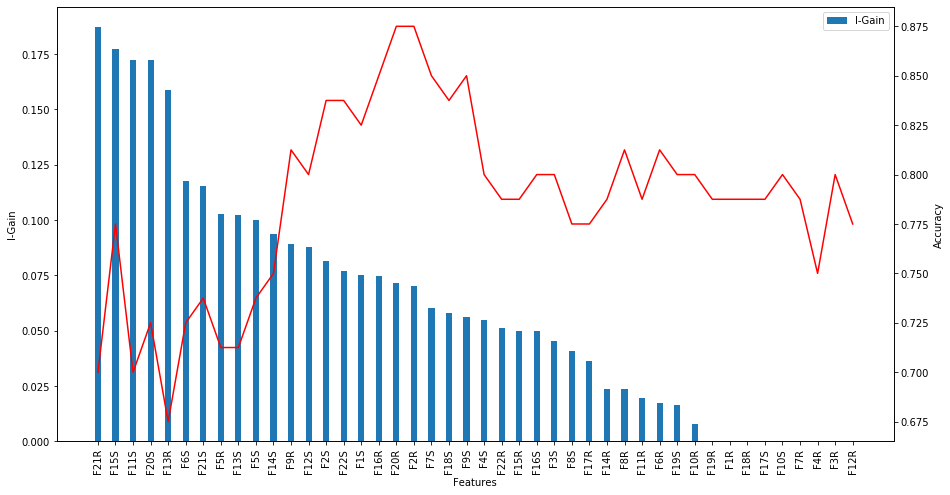

In [7]:
IG_DF['Accuracy'] = test_score
import matplotlib.pyplot as plt
%matplotlib inline

n = len(IG_DF.index)
rr = range(1,n)
fig, ax = plt.subplots(figsize=(15,8))
ax2 = ax.twinx()
ax.bar(IG_DF.index, IG_DF["I-Gain"], label='I-Gain',width=.35)
ax2.plot(IG_DF.index,IG_DF["Accuracy"], color='red', label='Accuracy')
ax.set_xticklabels(list(IG_DF.index), rotation = 90)
ax.set_xlabel('Features')
ax.set_ylabel('I-Gain')
ax2.set_ylabel('Accuracy')
ax.legend()
# plot the IG scores and the average cross validation scores
plt.show()

##### As the result shown above, the subset including the features with the top 18 and 19 highest IG shows the highest average cross validation scores. 
##### Therefore, we can choose the former one as the best feature subset, because its data-scale is a bit smaller than the latter.

In [8]:
# calculate the cross validation score with the 18 best features on train dataset
X_train_new = train_data[IG_DF.index[:18]].values
score1 = cross_val_score(gb, X_train_new, y_train, cv = 10).mean()
print("The best 18 features are:{}".format(list(IG_DF.index[:18])))

The best 18 features are:['F21R', 'F15S', 'F11S', 'F20S', 'F13R', 'F6S', 'F21S', 'F5R', 'F13S', 'F5S', 'F14S', 'F9R', 'F12S', 'F2S', 'F22S', 'F1S', 'F16R', 'F20R']


#### Testing the accuracy on test data

In [9]:
# calculate the acuuracy by hold out testing on test dataset.
FS_X_test = test_data[IG_DF.index[:18]].values
model = gb.fit(X_train_new, y_train)
y_dash = model.predict(FS_X_test)
score4 = accuracy_score(y_test, y_dash)

## Wrapper-based forward sequential search
##### Try to calculate the accuracy of based on cross-validation.
##### set `k_features` as the number of all features at first in order to figure out K best features.

In [10]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

sfs_forward = SFS(gb, 
                  k_features=44, 
                  forward=True, 
                  floating=False, 
                  verbose=1,
                  scoring='accuracy',
                  cv=10, n_jobs = -1)

sfs_forward = sfs_forward.fit(X_train, y_train, 
                              custom_feature_names=train_data.columns)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  44 out of  44 | elapsed:   15.3s finished
Features: 1/44[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  43 out of  43 | elapsed:   14.6s finished
Features: 2/44[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 out of  42 | elapsed:   13.3s finished
Features: 3/44[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  41 out of  41 | elapsed:   11.7s finished
Features: 4/44[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   10.9s finished
Features: 5/44[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  39 out of  39 | elapsed:    9.9s finished
Features: 6/44[Parallel(n_jobs=-1)]: Using backe

In [12]:
forward_DF  = pd.DataFrame.from_dict(sfs_forward.get_metric_dict()).T
forward_DF.sort_values(by = 'avg_score', ascending = False, inplace = True)
forward_DF

,avg_score,ci_bound,cv_scores,feature_idx,feature_names,std_dev,std_err
25,0.9,0.0909634,"[0.875, 0.875, 1.0, 1.0, 0.625, 0.75, 1.0, 0.8...","(1, 2, 3, 4, 5, 8, 9, 10, 12, 13, 14, 15, 16, ...","(F1S, F2R, F2S, F3R, F3S, F5R, F5S, F6R, F7R, ...",0.122474,0.0408248
27,0.8875,0.0875842,"[0.875, 0.875, 1.0, 0.875, 0.625, 0.75, 1.0, 0...","(1, 2, 3, 4, 5, 6, 8, 9, 10, 12, 13, 14, 15, 1...","(F1S, F2R, F2S, F3R, F3S, F4R, F5R, F5S, F6R, ...",0.117925,0.0393083
24,0.8875,0.0969269,"[0.875, 0.875, 1.0, 1.0, 0.625, 0.75, 1.0, 0.7...","(1, 2, 3, 4, 5, 8, 9, 10, 12, 13, 14, 15, 16, ...","(F1S, F2R, F2S, F3R, F3S, F5R, F5S, F6R, F7R, ...",0.130504,0.0435013
29,0.8875,0.0875842,"[0.875, 0.875, 1.0, 0.875, 0.625, 0.75, 1.0, 0...","(1, 2, 3, 4, 5, 6, 8, 9, 10, 12, 13, 14, 15, 1...","(F1S, F2R, F2S, F3R, F3S, F4R, F5R, F5S, F6R, ...",0.117925,0.0393083
28,0.8875,0.0875842,"[0.875, 0.875, 1.0, 0.875, 0.625, 0.75, 1.0, 0...","(1, 2, 3, 4, 5, 6, 8, 9, 10, 12, 13, 14, 15, 1...","(F1S, F2R, F2S, F3R, F3S, F4R, F5R, F5S, F6R, ...",0.117925,0.0393083
33,0.875,0.0719129,"[0.875, 0.875, 0.875, 0.875, 0.75, 0.75, 1.0, ...","(0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 12, 13, 14, 15...","(F1R, F1S, F2R, F2S, F3R, F3S, F4R, F5R, F5S, ...",0.0968246,0.0322749
26,0.875,0.0830378,"[0.875, 0.875, 0.875, 0.875, 0.625, 0.75, 1.0,...","(1, 2, 3, 4, 5, 6, 8, 9, 10, 12, 13, 14, 15, 1...","(F1S, F2R, F2S, F3R, F3S, F4R, F5R, F5S, F6R, ...",0.111803,0.0372678
30,0.875,0.0830378,"[0.875, 0.875, 1.0, 0.875, 0.625, 0.75, 1.0, 0...","(1, 2, 3, 4, 5, 6, 8, 9, 10, 12, 13, 14, 15, 1...","(F1S, F2R, F2S, F3R, F3S, F4R, F5R, F5S, F6R, ...",0.111803,0.0372678
31,0.875,0.1017,"[0.875, 0.875, 0.875, 1.0, 0.625, 0.625, 1.0, ...","(1, 2, 3, 4, 5, 6, 8, 9, 10, 12, 13, 14, 15, 1...","(F1S, F2R, F2S, F3R, F3S, F4R, F5R, F5S, F6R, ...",0.136931,0.0456435
32,0.875,0.0587166,"[0.875, 0.875, 0.875, 0.875, 0.75, 0.75, 1.0, ...","(1, 2, 3, 4, 5, 6, 8, 9, 10, 12, 13, 14, 15, 1...","(F1S, F2R, F2S, F3R, F3S, F4R, F5R, F5S, F6R, ...",0.0790569,0.0263523


##### According to the results shown above, the subset with 25 best features could be considered as the greatest choice.
##### Because it has the highest average cross-validation score.

In [31]:
# calculate the cross validation score with the 25 best features on train dataset
forward_FS = forward_DF['feature_names'].values[0]
X_train_new = train_data[list(forward_FS)].values
score2 = cross_val_score(gb,X_train_new,y_train,cv =10).mean()
print("The 25 best selected features are:{}".format(list(forward_FS)))

The best selected features are:['F1S', 'F2R', 'F2S', 'F3R', 'F3S', 'F5R', 'F5S', 'F6R', 'F7R', 'F7S', 'F8R', 'F8S', 'F9R', 'F10R', 'F11R', 'F12R', 'F12S', 'F13R', 'F13S', 'F14R', 'F18R', 'F18S', 'F20S', 'F21S', 'F22S']


#### Test the accuracy with test data

In [32]:
# calculate the acuuracy by hold out testing on test dataset.
X_test_new = test_data[list(forward_FS)].values
model = gb.fit(X_train_new, y_train)
y_dash = model.predict(X_test_new)
score5 = accuracy_score(y_test, y_dash)

### Wrapper-based backward elimination.
##### Try to calculate the accuracy of based on cross-validation.
##### Set the `k_features` as 1 at first, in order to figure out the best K features.

In [20]:
sfs_backward = SFS(gb, 
                  k_features= 1, 
                  forward=False, 
                  floating=False, 
                  verbose=1,
                  scoring='accuracy',
                  cv=10, n_jobs = -1)

sfs_backward = sfs_backward.fit(X_train, y_train, 
                              custom_feature_names=train_data.columns)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  44 out of  44 | elapsed:   11.5s finished
Features: 43/1[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  43 out of  43 | elapsed:   11.3s finished
Features: 42/1[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 out of  42 | elapsed:   13.6s finished
Features: 41/1[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  41 out of  41 | elapsed:   13.2s finished
Features: 40/1[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   10.8s finished
Features: 39/1[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  39 out of  39 | elapsed:   10.9s finished
Features: 38/1[Parallel(n_jobs=-1)]: Using backe

In [22]:
back_DF = pd.DataFrame.from_dict(sfs_backward.get_metric_dict()).T
back_DF.sort_values(by = 'avg_score', ascending = False, inplace = True)
back_DF

,avg_score,ci_bound,cv_scores,feature_idx,feature_names,std_dev,std_err
12,0.925,0.0742713,"[0.875, 1.0, 1.0, 1.0, 0.75, 0.75, 1.0, 0.875,...","(1, 2, 4, 6, 8, 9, 11, 16, 25, 26, 39, 40)","(F1S, F2R, F3R, F4R, F5R, F5S, F6S, F9R, F13S,...",0.1,0.0333333
13,0.925,0.0742713,"[0.875, 1.0, 1.0, 1.0, 0.75, 0.75, 1.0, 0.875,...","(1, 2, 4, 6, 8, 9, 11, 16, 25, 26, 33, 39, 40)","(F1S, F2R, F3R, F4R, F5R, F5S, F6S, F9R, F13S,...",0.1,0.0333333
14,0.9125,0.0835552,"[0.875, 1.0, 1.0, 1.0, 0.75, 0.75, 1.0, 0.75, ...","(1, 2, 4, 6, 8, 9, 11, 12, 16, 25, 26, 33, 39,...","(F1S, F2R, F3R, F4R, F5R, F5S, F6S, F7R, F9R, ...",0.1125,0.0375
17,0.9125,0.0835552,"[0.875, 1.0, 1.0, 1.0, 0.75, 0.75, 1.0, 0.75, ...","(1, 2, 4, 5, 6, 8, 9, 11, 12, 16, 24, 25, 26, ...","(F1S, F2R, F3R, F3S, F4R, F5R, F5S, F6S, F7R, ...",0.1125,0.0375
10,0.9125,0.0725097,"[0.875, 1.0, 0.875, 1.0, 0.75, 0.75, 1.0, 0.87...","(1, 2, 4, 8, 9, 11, 16, 25, 39, 40)","(F1S, F2R, F3R, F5R, F5S, F6S, F9R, F13S, F20S...",0.0976281,0.0325427
11,0.9125,0.0725097,"[0.875, 1.0, 0.875, 1.0, 0.75, 0.75, 1.0, 0.87...","(1, 2, 4, 6, 8, 9, 11, 16, 25, 39, 40)","(F1S, F2R, F3R, F4R, F5R, F5S, F6S, F9R, F13S,...",0.0976281,0.0325427
15,0.9125,0.0835552,"[0.75, 1.0, 1.0, 1.0, 0.75, 0.75, 1.0, 0.875, ...","(1, 2, 4, 5, 6, 8, 9, 11, 12, 16, 25, 26, 33, ...","(F1S, F2R, F3R, F3S, F4R, F5R, F5S, F6S, F7R, ...",0.1125,0.0375
16,0.9125,0.0835552,"[0.875, 1.0, 1.0, 1.0, 0.75, 0.75, 1.0, 0.75, ...","(1, 2, 4, 5, 6, 8, 9, 11, 12, 16, 25, 26, 28, ...","(F1S, F2R, F3R, F3S, F4R, F5R, F5S, F6S, F7R, ...",0.1125,0.0375
23,0.9,0.0999908,"[0.875, 1.0, 1.0, 1.0, 0.75, 0.625, 1.0, 0.75,...","(0, 1, 2, 4, 5, 6, 8, 9, 11, 12, 16, 21, 24, 2...","(F1R, F1S, F2R, F3R, F3S, F4R, F5R, F5S, F6S, ...",0.134629,0.0448764
21,0.9,0.0999908,"[0.875, 1.0, 1.0, 1.0, 0.75, 0.625, 1.0, 0.75,...","(1, 2, 4, 5, 6, 8, 9, 11, 12, 16, 21, 24, 25, ...","(F1S, F2R, F3R, F3S, F4R, F5R, F5S, F6S, F7R, ...",0.134629,0.0448764


##### According to the results shown above, the subset with 12 best features could be considered as the greatest choice.
##### Because it has the highest average cross-validation score.
##### Although the subset with 13 best features has the same cross-validation score and the std-score, 
##### but the data scale of it is a bit larger than that of the former.
##### Therefore, the subset with 12 best features could be considered as the greatest choice.

In [36]:
# calculate the cross validation score with the 12 best features on train dataset
back_FS = back_DF['feature_names'].values[0]
X_train_new = train_data[list(back_FS)].values
score3 = cross_val_score(gb,X_train_new,y_train,cv =10).mean()

### Test the accuracy on test data

In [38]:
# calculate the acuuracy by hold out testing on test dataset.
X_test_new = test_data[list(back_FS)].values
model = gb.fit(X_train_new, y_train)
y_dash = model.predict(X_test_new)
score6 = accuracy_score(y_test, y_dash)

#### If it does not have the process of feature selection, directly calculating the average cross-validation scores on all training data, and the hold-out testing scores on the test dataset.

In [39]:
# calculate the cross validation score with all features on train dataset
score_train = cross_val_score(gb, X_train, y_train, cv = 10, scoring = 'accuracy').mean()

In [40]:
# calculate the acuuracy by hold out testing on test dataset.
model = gb.fit(X_train, y_train)
y_dash = model.predict(X_test)
score_test = accuracy_score(y_test, y_dash)

### Plot the bar chart of accuracy based on different feature selection strategies.

(0.5, 1.0)

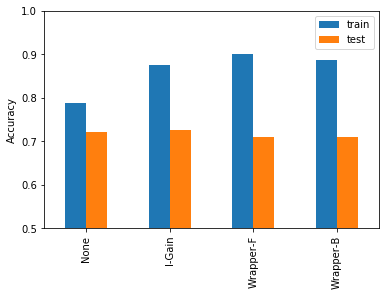

In [45]:
train_bar = [score_train,score1,score2,score3]
test_bar = [score_test,score4,score5,score5]
index = ['None','I-Gain','Wrapper-F','Wrapper-B']
df = pd.DataFrame({'train':train_bar, 'test': test_bar},index = index)
pl = df.plot.bar()
pl.set_ylabel("Accuracy")
pl.set_ylim([0.5,1.0])

In [46]:
df

,train,test
None,0.7875,0.721925
I-Gain,0.8750,0.727273
Wrapper-F,0.9000,0.711230
Wrapper-B,0.8875,0.711230


### Accuracy analytics on training data
According to the results shown above, feature selection leads to a dramatic increase in the prediction accuracy on the training set, when applying the three feature selection strategies. The wrapper-based forward sequential search has the highest accuracy on training data, which reaches 0.9, While Information Gain has the lowest accuracy among these three strategies, with 0.875 true predictions. The reason why the wrapper-based filter has advantages is that they consider the bias of specific learning algorithms, which the Information Gain method cannot do. Another benefit for the wrapper-based filter is that they take feature dependencies into account, while the feature combination is only from the highest IG score to the lower IG score when using the Information Gain filter.

### Accuracy analytics on test data
Information Gain shows the best performance on test data, with 0.727 true prediction, which is the only strategy that can slightly improve the accuracy scores when testing on test data. On the other hand, when applying the wrapper-based forward sequential search and backward elimination, it leads to a slight decrease in accuracy when testing on the test data. One reason leads to this result is the data scale of training data is much smaller than that of test data, with 80 objects in training data set and 187 items in test set respectively. Therefore, the selected features in this assignment could not represent the whole data set for prediction to some extent. In order to increase the accuracy in test data, we could adjust the loss function and other parameters in the GB classifier.

### time-consuming
Information gain is faster than the wrapper-based filters because the feature dependencies are not considered.

### Stability analysis
The Gradient Boosting Classifier has a significant influence on the accuracy results unless we set `random_state` as a specific value. Moreover, the Information Gain filter could be considered a bit unstable, because every time it gets different IG scores and IG ranks for each feature if we do not set the `random_state` value for `mutual_info_classif` function. It means every time we could select different features because of random factors. Thus, the Information Gain filter is not stable to some extent. On the other hand, two wrapper-based filters are more stable because their results for each future combination would not change if the GB classifier has a random seed. It is likely because they are more comprehensive when they take the bias of learning algorithms and feature dependencies into account.